## Forward calculations using pyMilne by Jaime de la Cruz 

In this section we are going to see how various atmosphere parameters influence the polarized line shape. By this we mean the shape of $I,Q,U,V$ profiles.

To do that we will use pyMilne module. pyMilne modules specifies the atmosphere via 9 parameters (6 ones we had in the scalar case + magnetic field vector). The line parameters (Lande factors, splitting, line center wavelengths, etc.), are stored in a file MilneEddington.py, that you should be able to change and add your own custom lines or modify existing ones.

Let's get started.


In [1]:
# Some common imports:
# This will allow us to calculate and plot thins. 
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

Now, the calculations are much more involved. There is splitting, etc, so we are using "out of the box" code and hiding it all elsewhere.

In [2]:
# This defines the range of wavelengths we are dealing with
regions = [[np.arange(401, dtype='float64')*0.005 + 6301.0, None]]

# This defines which lines are taken into account, by their names (take a look at MilneEddington.py)
lines   = [6301,6302]

In [3]:
# Here we define an object (object is basically a variable that can do functions too)
# Object knows about the lines, wavelength grid, and even about number of threads, since we can calculate
# many spectral in parallel :) Objects are truly wonders of programmin.

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

#### We have now defined the "general" outline of our problem. Now we can define many models and see how does each model parameter affect outgoing polarization.

In [4]:
# These are the parameter names and units, for easier reference
param_names = ['|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1']

# We will refer to the specific parameter values as "model"
model_in = np.array([1000., np.pi/4., np.pi/8, 0.0, 0.02, 30., 0.1, 0.2, 0.8])

# This package is made with paralellization in mind so we first need to pass our model(s) to the "me"
# object, and then we can calculate the synthesis
ny = 1
nx = 1
model = me.repeat_model(model_in, ny, nx)
model.shape


(1, 1, 9)

In [5]:
# Then we use the "synthesize" method of the object "me", while providing the "model", and the famous
# "mu" ("mu = cos \theta")

syn = me.synthesize(model, mu = 1.0)
syn.shape


(1, 1, 4, 401)

We got a 1 x 1 x 4 x 201 array of numbers! 

1 x 1 is number of models we used (it is already apparent we can use this to deal with a separate model for each pixel) 

4 is for 4 Stokes parameters 

And 201 is 201 wavelength point! 

In [8]:
# A tad weird way to extract our wavelength ;) 
ll = np.squeeze(regions[0])[0]

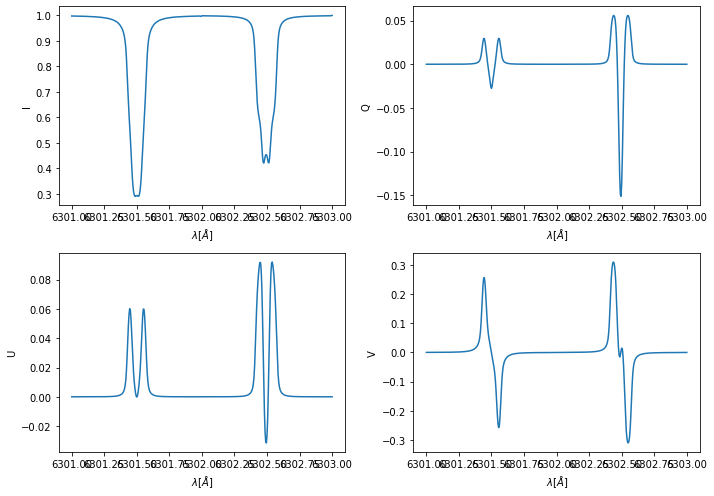

In [9]:
# And we can do the plotting! 

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn[0,0,0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn[0,0,1])
plt.subplot(223)
plt.plot(ll,syn[0,0,2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn[0,0,3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")
plt.tight_layout()


### We can now spend a couple of minutes discussing about the shapes of these profiles...
#### Now, let's try to repeat the exercise from the scalar problem and see how it looks like using this code. 

Text(0, 0.5, 'Intensity')

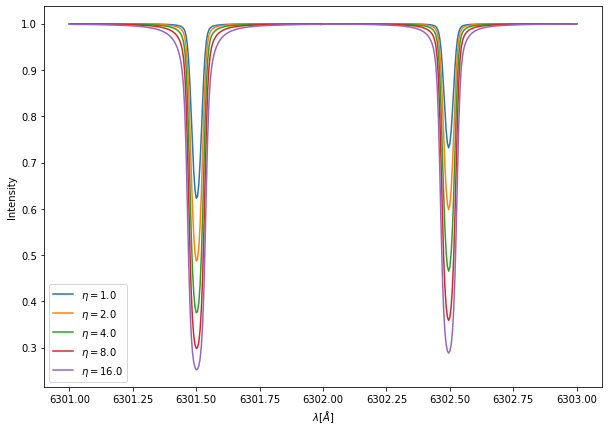

In [10]:
# Let's turn off magnetic field as we are going to try and reproduce the scalar case: 

param = ['|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1']
etavar = 1.0
m_in = np.float64([0., 1.0, 0.39, 0.1, 0.02, etavar, 0.1, 0.2, 0.8])
ny = 1
nx = 1
model = me.repeat_model(m_in, nx, ny)
syn =  me.synthesize(model, mu = 1.0)
plt.figure(figsize=[10,7])
plt.plot(ll,syn[0,0,0],label='$\eta = $'+str(m_in[5]))

for i in range(1,5):
    etavar *= 2.0
    m_in = np.float64([0., 1.0, 0.39, 0.1, 0.02, etavar, 0.1, 0.2, 0.8])
    model = me.repeat_model(m_in, ny, nx)
    syn =  me.synthesize(model, mu = 1.0)
    plt.plot(ll,syn[0,0,0],label='$\eta = $'+str(m_in[5]))
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")

Great! This looks very similar to the ones we calculated earlier! 

But now let's see an alternative way to do this:

In [12]:
m_in = np.float64([0., np.pi/4., np.pi/8., 0.0, 0.02, etavar, 0.1, 0.2, 0.8])
nx = 1
ny = 10
model = np.zeros([nx,ny,9])
#Model is an array that has dimensions nx,ny and then 9 for the number of parameters
for i in range(0,10):
    model[0,i,:] = m_in
    model[0,i,5] = 2.0 ** i
    
model.shape

(1, 10, 9)

In [13]:
# our object can synthesize many pixels at the same time
syn =  me.synthesize(model, mu = 1.0)
syn.shape

(1, 10, 4, 401)

Text(0, 0.5, 'Intensity')

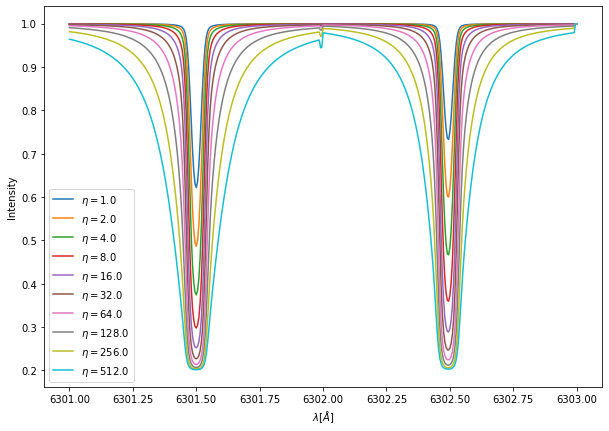

In [14]:
plt.figure(figsize=[10,7])
for i in range(0,10):
    plt.plot(ll,syn[0,i,0],label='$\eta = $'+str(model[0,i,5]))
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")

### Voila! Amazing! 

Before leaving you to play with this, let's do an example for the full Stokes, and playing with the magnetic field.

Text(0, 0.5, 'Intensity')

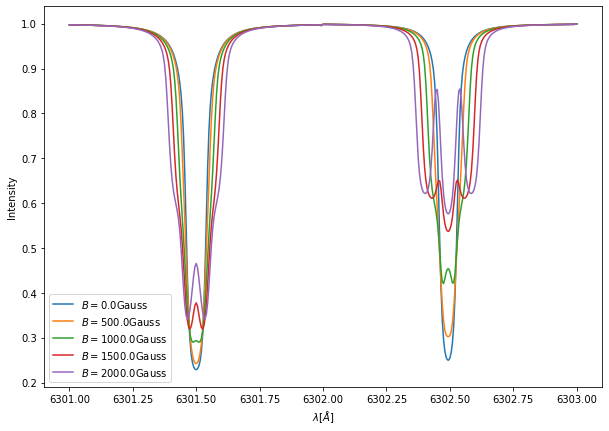

In [33]:
m_in = np.float64([0., np.pi/4., 0.0, 0.0, 0.02, 30.0, 0.1, 0.2, 0.8])
nx = 1
ny = 5
model = np.zeros([nx,ny,9])
#Model is an array that has dimensions nx,ny and then 9 for the number of parameters
for i in range(0,5):
    model[0,i,:] = m_in
    model[0,i,0] = i*500 # magnetic field

syn =  me.synthesize(model, mu = 1.0)

plt.figure(figsize=[10,7])
for i in range(0,5):
    plt.plot(ll,syn[0,i,0],label='$B = $'+str(model[0,i,0])+'Gauss')
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")

Text(0, 0.5, 'Stokes V')

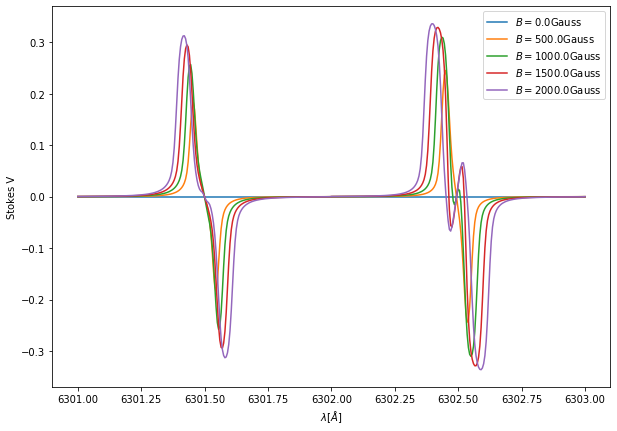

In [34]:
plt.figure(figsize=[10,7])
for i in range(0,5):
    plt.plot(ll,syn[0,i,3],label='$B = $'+str(model[0,i,0])+'Gauss')
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Stokes V")

Text(0, 0.5, 'Stokes V')

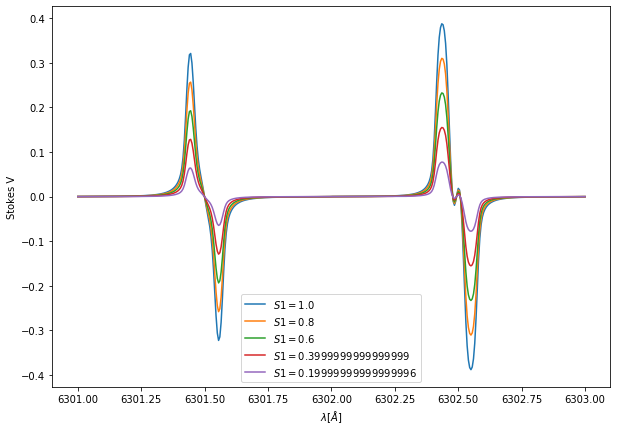

In [36]:
m_in = np.float64([1000., np.pi/4., 0.0, 0.0, 0.02, 30.0, 0.1, 0.2, 0.8])
nx = 1
ny = 5
model = np.zeros([nx,ny,9])
#Model is an array that has dimensions nx,ny and then 9 for the number of parameters
for i in range(0,5):
    model[0,i,:] = m_in
    model[0,i,-2] = i*0.2 # magnetic field
    model[0,i,-1] = 1.0 - model[0,i,-2]

syn =  me.synthesize(model, mu = 1.0)

plt.figure(figsize=[10,7])
for i in range(0,5):
    plt.plot(ll,syn[0,i,3],label='$S1 = $'+str(model[0,i,-1]))
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Stokes V")

Text(0, 0.5, 'Intensity')

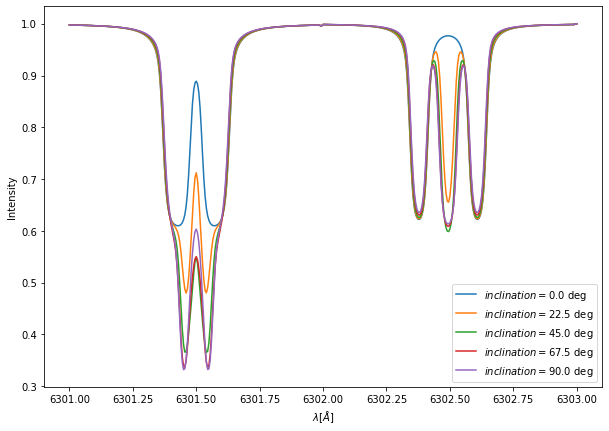

In [37]:
m_in = np.float64([2500., np.pi/4., 0.0, 0.0, 0.02, 30.0, 0.1, 0.2, 0.8])
nx = 1
ny = 5
model = np.zeros([nx,ny,9])
#Model is an array that has dimensions nx,ny and then 9 for the number of parameters
for i in range(0,5):
    model[0,i,:] = m_in
    model[0,i,1] = np.pi/2.*i / 4.

syn =  me.synthesize(model, mu = 1.0)

plt.figure(figsize=[10,7])
for i in range(0,5):
    plt.plot(ll,syn[0,i,0],label='$inclination = $'+str(model[0,i,1]*180./np.pi)+' deg')
plt.legend()
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")